In [13]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sortedcontainers import SortedList
from sklearn.model_selection import train_test_split
import math
import re
from datetime import datetime


In [14]:
# Tien xu lli du lieu
file_path = '../dataset/test.likes.csv'
data = []
with open(file_path, 'r', newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        data.append(row)
for row in data:
    del row['_id']
    del row['createdAt']
    del row['__v']
    row['liked'] = 1
with open('liked_final.csv', 'w', newline='') as file:
    fieldnames = data[0].keys()
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for row in data:
        writer.writerow(row)


In [15]:
df = pd.read_csv('liked_final.csv')
tour_df = pd.read_csv('../dataset/test.tours.csv')
df = shuffle(df)

df_train, df_test = train_test_split(df)


In [16]:
print(df_train)

                         user                      tour  liked
142  65df8d42436815dc27fb0f9d  65db0c320b1aa37831a6b6bf      1
164  65df8e6b436815dc27fb120d  65db0c2b0b1aa37831a6b693      1
110  65df8be2436815dc27fb0c8c  65db0c3e0b1aa37831a6b705      1
170  65df8e6b436815dc27fb120d  65db0c290b1aa37831a6b687      1
239  65df9134436815dc27fb1859  65db0c110b1aa37831a6b5fd      1
..                        ...                       ...    ...
85   65df89be436815dc27fb09e9  65db0c4a0b1aa37831a6b749      1
217  65df902f436815dc27fb15fe  65db0c180b1aa37831a6b629      1
160  65df8e10436815dc27fb1144  65db0c2c0b1aa37831a6b69b      1
251  65df919f436815dc27fb1921  65db0c0d0b1aa37831a6b5e5      1
95   65df8b88436815dc27fb0bc4  65db0c440b1aa37831a6b723      1

[190 rows x 3 columns]


In [17]:
# list tour user liked
user_to_tour = {}
# list user liked tour
tour_to_user = {}
#  (tour_id, user_id) và giá trị là trạng thái "liked" của tour đó từ người dùng.
tour_user_liked = {}

tour_user_liked_train = {}
tour_user_liked_test = {}


for row in df.values:
    user_id, tour_id, liked = row
    if tour_id not in user_to_tour:
        user_to_tour[user_id] = [tour_id]
    else:
        user_to_tour[user_id].append(tour_id)
    
    if tour_id not in tour_to_user:
        tour_to_user[tour_id] = [user_id]
    else:
        tour_to_user[tour_id].append(user_id)
    
    tour_user_liked[(tour_id, user_id)] = liked



In [18]:
# giá trị của tour_user_liked_train với trạng thái "liked" tương ứng với cặp (tour_id, user_id).
for row in df_train.values:
    user_id, tour_id, liked = row
    tour_user_liked_train[(tour_id, user_id)] = liked
# giá trị của tour_user_liked_test với trạng thái "liked" tương ứng với cặp (tour_id, user_id).
for row in df_test.values:
    user_id, tour_id, liked = row
    tour_user_liked_test[(tour_id, user_id)] = liked


In [19]:
number_of_tour= int(len(tour_to_user.keys()))
number_of_user = int(len(user_to_tour.keys()))

print(f'Number of movie has liked: {number_of_tour}')
print(f'Number of user liked: {number_of_user}')

Number of movie has liked: 222
Number of user liked: 32


In [20]:
# latent dimensionality
k = 30
# W là ma trận hệ số cho người dùng
W = dict.fromkeys(user_to_tour.keys())
# U là ma trận hệ số cho tour
U = dict.fromkeys(tour_to_user.keys())
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# giá trị đều là None.
# print(W)
# print(U)

In [21]:
def get_rating(user_id, tour_id):
    return sigmoid(np.dot(W[user_id], U[tour_id]))
def convert_to_hours(period_string):
        try:
            days = int(period_string.split('ngày')[0])
        except:
            days = 0
        try:
            nights = int(period_string.split('đêm')[0])
        except:
            nights = 0
        total_hours = (days + nights) * 12
        return total_hours
def get_rating_content_based(user_id, tour_id):
    tours = {}
    for row in tour_df.values:
        _id,name,description,price,departureLocation,period,images,destination,departureDay,createdAt,__v,numLikes = row
        tours[_id] = {
            'name': name,
            'description': description,
            'price': price,
            'departureLocation': departureLocation,
            'period': convert_to_hours(period),
            'images': images,
            'destination': destination,
            'departureDay': departureDay,
            'createdAt': createdAt,
            'numLikes': numLikes
        }
    def get_sim_name(tour_id_i,tour_id_j):
        name_i = tours[tour_id_i]['name']
        name_j = tours[tour_id_j]['name']

        if(name_i == name_j):
            return 1

        return 0

    def get_sim_departureLocation(tour_id_i,tour_id_j):
        departureLocation_i = set(tours[tour_id_i]['departureLocation'])
        departureLocation_j = set(tours[tour_id_j]['departureLocation'])

        if(departureLocation_i == departureLocation_j):
            return 1
        return 0 
    
    def get_sim_price(tour_id_i,tour_id_j):
        price_i = tours[tour_id_i]['price']
        price_j = tours[tour_id_j]['price']

        if price_i == 0 or price_j == 0:
            return 0
        max_price = max(price_i, price_j)

        min_price = min(price_i, price_j)

        similarity = abs(min_price / max_price)
        
        return similarity

    def get_sim_period(tour_id_i,tour_id_j):
        period_i = tours[tour_id_i]['period']
        period_j = tours[tour_id_j]['period']
        diff = abs(period_i - period_j)
        if diff <= 12:
            return 1
        elif diff <= 24:
            return 0.8
        elif diff <= 48:
            return 0.6
        return 0
    
    def get_sim_departureDays(tour_id_i,tour_id_j):
        departure_day_i = datetime.fromisoformat(tours[tour_id_i]['departureDay'].split('T')[0])
        departure_day_j = datetime.fromisoformat(tours[tour_id_j]['departureDay'].split('T')[0])

        similarity = 1 / (1 + abs((departure_day_i - departure_day_j).days))

        return similarity
    def get_tour_similarities(tour_id_i,tour_id_j):
        sim_name = get_sim_name(tour_id_i,tour_id_j)
        sim_departureLocation = get_sim_departureLocation(tour_id_i,tour_id_j)
        sim_price = get_sim_price(tour_id_i,tour_id_j)
        sim_period = get_sim_period(tour_id_i,tour_id_j)
        sim_departureDays = get_sim_departureDays(tour_id_i,tour_id_j)
        return 0.2 * (sim_name + sim_departureLocation + sim_price + sim_period + sim_departureDays)
    sim = []
    for tour_id_user_liked in user_to_tour[user_id]:
        sim.append(get_tour_similarities(tour_id_user_liked, tour_id))
    print('final_rating', np.mean(sim) * get_rating(user_id, tour_id))
    return np.mean(sim) * get_rating(user_id, tour_id)





In [27]:
# mỗi user_id trong W sẽ được gán một vector ngẫu nhiên có k phần tử
# mỗi movie_id trong U sẽ được gán một vector ngẫu nhiên có k phần tử
# Đoạn mã này chuẩn bị các giá trị ban đầu ngẫu nhiên cho ma trận hệ số W và U,
def dump():
    for user_id in W.keys():
        W[user_id] = np.random.randn(k)
    for movie_id in U.keys():
        U[movie_id] = np.random.randn(k)
def matrix_fact(args):
    tour_id, user_id, learning_rate, _ = args
    rate = tour_user_liked_train[(tour_id, user_id)]
    # sai so giua gia tri tap train va gia tri du doan
    error = rate - np.dot(W[user_id], U[tour_id])
    
    saved_w = np.copy(W[user_id])
    saved_u = np.copy(U[tour_id])
    
    # Cap nhat lai gia tri du doan
    W[user_id] += 2 * learning_rate * error * saved_u
    U[tour_id] += 2 * learning_rate * error * saved_w

    return error ** 2

def evaluate():
    loss = 0
    for tour_id, user_id in tour_user_liked_test:
        liked = tour_user_liked_test[(tour_id, user_id)]
        # sai so giua gia tri thuc te va gia tri du doan
        error = liked - get_rating(user_id, tour_id)
        # mat mat = error ^ 2
        loss += error ** 2
    return (loss, math.sqrt(loss / len(tour_user_liked_test)))
# fit(100, 0.01, 0.2, matrix_fact, evaluate)
def fit(epoch, learning_rate, weight, update_func, evaluate_func):
    losses_train = []
    losses_validation = []

    rmse_train = []
    rmse_validation = []

    dump()

    for i in range(0, epoch):
        loss = 0    
        
        for tour_id, user_id in tour_user_liked_train:
            loss += update_func((tour_id, user_id, learning_rate, weight))

        rmse = math.sqrt(loss / len(tour_user_liked_train))

        loss_test, rmse_test = evaluate_func()
        
        losses_train.append(loss)
        losses_validation.append(loss_test)

        rmse_train.append(rmse)
        rmse_validation.append(rmse_test)

        print(f'Epoch: {i + 1}/{epoch}')
        print('Loss: ' , loss, 'RMSE: ', rmse, 'Loss_Test: ', loss_test, 'RMSE_Test: ', rmse_test)

    x_axis = list(range(1, epoch + 1))
    fig, axis = plt.subplots(nrows = 1, ncols = 2)

    axis[0].plot(x_axis, losses_train, color = 'red', label = 'Loss Train')
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Loss')

    axis[0].plot(x_axis, losses_validation, color = 'blue', label = 'Loss Test')
    axis[0].legend(loc = 'upper right')

    axis[1].plot(x_axis, rmse_train, color = 'red', label = 'RMSE Train')
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('RMSE')

    axis[1].plot(x_axis, rmse_validation, color = 'blue', label = 'RMSE Test')
    axis[1].legend(loc = 'upper right')
    plt.show()

Epoch: 1/100
Loss:  4178.892169691556 RMSE:  4.6897941654369095 Loss_Test:  25.94233458944907 RMSE_Test:  0.6366702270093535
Epoch: 2/100
Loss:  352.6655683851754 RMSE:  1.3624002974340146 Loss_Test:  25.77721362859932 RMSE_Test:  0.6346408141199747
Epoch: 3/100
Loss:  40.600232733934085 RMSE:  0.462261219919818 Loss_Test:  25.78254980690381 RMSE_Test:  0.634706499677506
Epoch: 4/100
Loss:  4.149969406681383 RMSE:  0.14779020348349037 Loss_Test:  25.758606070880134 RMSE_Test:  0.6344117116333069
Epoch: 5/100
Loss:  0.4048463260762853 RMSE:  0.046160265783935936 Loss_Test:  25.76985286411402 RMSE_Test:  0.6345501958094265
Epoch: 6/100
Loss:  0.058008454597189216 RMSE:  0.017473055135684777 Loss_Test:  25.76840816400683 RMSE_Test:  0.6345324085991249
Epoch: 7/100
Loss:  0.010028520560191621 RMSE:  0.007265100629647416 Loss_Test:  25.769607712468446 RMSE_Test:  0.6345471775268718
Epoch: 8/100
Loss:  0.0017682220202285615 RMSE:  0.0030506444705034838 Loss_Test:  25.770178899353652 RMSE_Tes

Epoch: 39/100
Loss:  2.2521734740913528e-23 RMSE:  3.44289770403955e-13 Loss_Test:  25.77080468286398 RMSE_Test:  0.6345619143706543
Epoch: 40/100
Loss:  6.744015463299443e-24 RMSE:  1.8840068531693776e-13 Loss_Test:  25.77080468286392 RMSE_Test:  0.6345619143706536
Epoch: 41/100
Loss:  2.007257596388851e-24 RMSE:  1.0278382005551496e-13 Loss_Test:  25.770804682863886 RMSE_Test:  0.6345619143706532
Epoch: 42/100
Loss:  5.979131541558365e-25 RMSE:  5.609733806217811e-14 Loss_Test:  25.77080468286387 RMSE_Test:  0.634561914370653
Epoch: 43/100
Loss:  1.778635931576148e-25 RMSE:  3.059614639973084e-14 Loss_Test:  25.770804682863858 RMSE_Test:  0.6345619143706529
Epoch: 44/100
Loss:  5.354864245540421e-26 RMSE:  1.6787940918754782e-14 Loss_Test:  25.77080468286385 RMSE_Test:  0.6345619143706528
Epoch: 45/100
Loss:  1.5901217177959664e-26 RMSE:  9.14825757869243e-15 Loss_Test:  25.770804682863847 RMSE_Test:  0.6345619143706527
Epoch: 46/100
Loss:  4.541657120632026e-27 RMSE:  4.889116334230

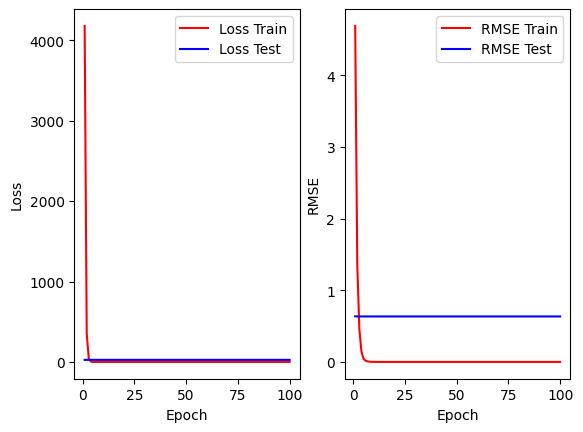

In [25]:
# fit(100, 0.01, 0.2, matrix_fact, evaluate)
fit(100, 0.01, 0.2, matrix_fact, evaluate)

In [26]:
def get_top_n(user_id, get_rating_func, n = 10):
    recommend_list = SortedList()
    for tour_id in tour_to_user.keys():
        if (tour_id, user_id) not in tour_to_user:
            rating = get_rating_func(user_id, tour_id)
            recommend_list.add((rating, tour_id))
            if len(recommend_list) > n:
                del recommend_list[0]
    return recommend_list

get_top_n('65bb108c8c4d4a714df1aaf4', get_rating_content_based)


rating 0.7310585786300049
sim 0.5313737846153846
final_rating 0.38846536370216944
rating 0.9176496315561983
sim 0.497659498901099
final_rating 0.45667705580703577
rating 0.9559260382473034
sim 0.45289759413919417
final_rating 0.43293660289721503
rating 3.0137798065155335e-06
sim 1.0
final_rating 3.0137798065155335e-06
rating 0.0015339062305816155
sim 0.5285019897435898
final_rating 0.0008106724949424733
rating 0.005795775655762706
sim 0.3975554655870446
final_rating 0.0023041422892648013
rating 0.13180972900557952
sim 0.5324646937062937
final_rating 0.07018402698246548
rating 0.9990823497570537
sim 0.537659498901099
final_rating 0.53716611553131
rating 0.040350416302726025
sim 0.5285019897435898
final_rating 0.021325275302972888
rating 0.021771232848208765
sim 0.5313737846153846
final_rating 0.011568662394295472
rating 0.5327797228028098
sim 0.5640648829431439
final_rating 0.3005223319772476
rating 0.00961340505413537
sim 0.5618649572649572
final_rating 0.005401435419912493
rating 0.06

SortedList([(0.5332341051883813, '65db0c170b1aa37831a6b61f'), (0.5335974305419503, '65db0c280b1aa37831a6b681'), (0.533897720744619, '65db0be10b1aa37831a6b4e7'), (0.5344907100049368, '65db0c1e0b1aa37831a6b64b'), (0.53716611553131, '65db0c630b1aa37831a6b7d7'), (0.5400590977795495, '65db0c280b1aa37831a6b685'), (0.5445683441999883, '65db0c130b1aa37831a6b60b'), (0.5610241177712831, '65db0c240b1aa37831a6b66b'), (0.5636172113778299, '65db0c270b1aa37831a6b67d'), (0.5738881052664498, '65db0c120b1aa37831a6b603')])